efficient net b0

In [15]:
import os
import json
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from PIL import Image
import matplotlib.pyplot as plt

In [16]:

# Define paths
images_dir = 'C:/Users/ARA/Desktop/Outfit-Aura/DeepFashion-MultiModal/images'
json_file_path = 'C:/Users/ARA/Desktop/Outfit-Aura/DeepFashion-MultiModal/captions.json'

# Load JSON data containing image descriptions
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Create a DataFrame with image names and captions
labels_df = pd.DataFrame(list(data.items()), columns=['image_name', 'caption'])

# Function to infer gender based on captions
def infer_gender(description):
    description = description.lower()
    if any(word in description.split() for word in ["man", "male", "gentleman", "guy"]):
        return 'male'
    elif any(word in description.split() for word in ["woman", "female", "lady", "girl"]):
        return 'female'
    return 'unknown'

# Add a column for gender based on descriptions from JSON
labels_df['gender'] = labels_df['caption'].apply(lambda x: infer_gender(x))

# Filter out images with 'unknown' gender
labels_df = labels_df[labels_df['gender'] != 'unknown']


In [17]:

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(labels_df, test_size=0.3, random_state=42, stratify=labels_df['gender'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['gender'])

# Define base directory for the split data
base_dir = 'C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data'
os.makedirs(base_dir, exist_ok=True)

# Define subdirectories for train, val, test for each gender
sub_dirs = ['train/male', 'train/female', 'val/male', 'val/female', 'test/male', 'test/female']
for sub_dir in sub_dirs:
    os.makedirs(os.path.join(base_dir, sub_dir), exist_ok=True)

def copy_images(image_names, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    total_images = len(image_names)
    for i, image_name in enumerate(image_names):
        src_path = os.path.join(images_dir, image_name)
        dst_path = os.path.join(target_dir, image_name)
        shutil.copyfile(src_path, dst_path)
        if i % 100 == 0:  # Log every 100 images
            print(f"Copied {i}/{total_images} images to {target_dir}")

# Copy images to the respective directories
for gender in ['male', 'female']:
    print(f"Copying {gender} images to train directory")
    copy_images(train_df[train_df['gender'] == gender]['image_name'], os.path.join(base_dir, 'train', gender))
    print(f"Copying {gender} images to val directory")
    copy_images(val_df[val_df['gender'] == gender]['image_name'], os.path.join(base_dir, 'val', gender))
    print(f"Copying {gender} images to test directory")
    copy_images(test_df[test_df['gender'] == gender]['image_name'], os.path.join(base_dir, 'test', gender))

print("Images have been successfully copied to respective directories for training, validation, and testing.")



Copying male images to train directory
Copied 0/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 100/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 200/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 300/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 400/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 500/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 600/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 700/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 800/2190 images to C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/data\train\male
Copied 900/2190 images to C

In [18]:
# Data generators with augmentation for training and only rescaling for validation and testing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(os.path.join(base_dir, 'train'),
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')

validation_generator = test_val_datagen.flow_from_directory(os.path.join(base_dir, 'val'),
                                                            target_size=(224, 224),
                                                            batch_size=32,
                                                            class_mode='binary')

test_generator = test_val_datagen.flow_from_directory(os.path.join(base_dir, 'test'),
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='binary')

# Correct Model Definition
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    callbacks=[early_stopping, reduce_lr])


Found 22995 images belonging to 2 classes.
Found 4928 images belonging to 2 classes.
Found 4928 images belonging to 2 classes.
Epoch 1/50


c:\Users\ARA\Desktop\Outfit-Aura\OUTFIT-AURA-web-application-\outfit\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


719/719 ━━━━━━━━━━━━━━━━━━━━ 1362s 2s/step - accuracy: 0.8947 - loss: 0.3342 - val_accuracy: 0.9046 - val_loss: 0.3152 - learning_rate: 0.0010
Epoch 2/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 2093s 3s/step - accuracy: 0.9031 - loss: 0.3237 - val_accuracy: 0.9046 - val_loss: 0.3155 - learning_rate: 0.0010
Epoch 3/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1513s 2s/step - accuracy: 0.9033 - loss: 0.3243 - val_accuracy: 0.9046 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 4/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 702s 972ms/step - accuracy: 0.9034 - loss: 0.3223 - val_accuracy: 0.9046 - val_loss: 0.3154 - learning_rate: 0.0010
Epoch 5/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 598s 827ms/step - accuracy: 0.9047 - loss: 0.3202 - val_accuracy: 0.9046 - val_loss: 0.3148 - learning_rate: 0.0010
Epoch 6/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 1361s 2s/step - accuracy: 0.9044 - loss: 0.3221 - val_accuracy: 0.9046 - val_loss: 0.3153 - learning_rate: 0.0010
Epoch 7/50
719/719 ━━━━━━━━━━━━━━━━━━━━ 658s 910ms/step - accuracy: 0.9022 - loss: 

In [19]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Save the model in the recommended Keras format
model.save('C:/Users/ARA/Desktop/Outfit-Aura/OUTFIT-AURA-web-application-/code/gender_classification_model.keras')

print("Model has been successfully saved in the Keras format.")


154/154 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9118 - loss: 0.2986
Test accuracy: 90.48%
Model has been successfully saved in the Keras format.


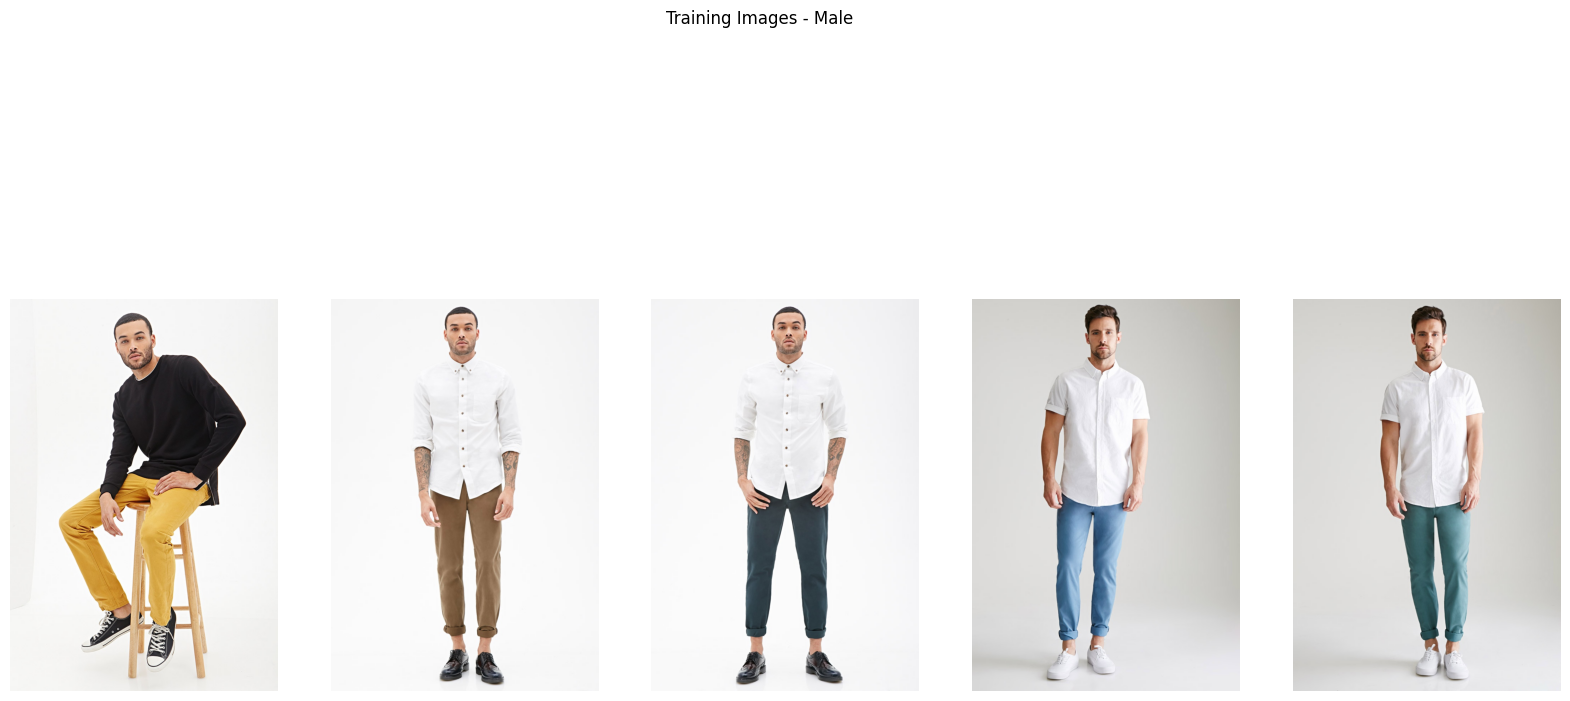

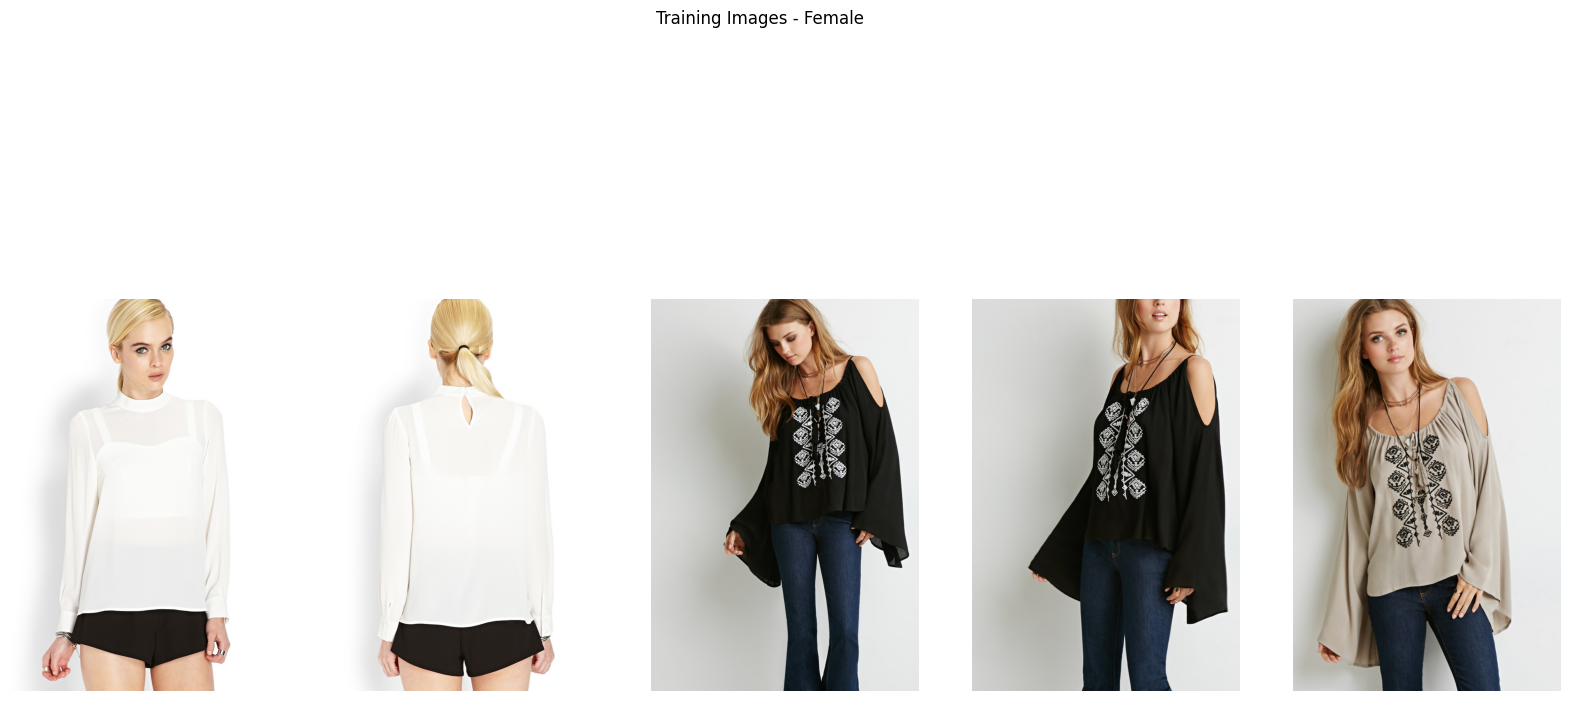

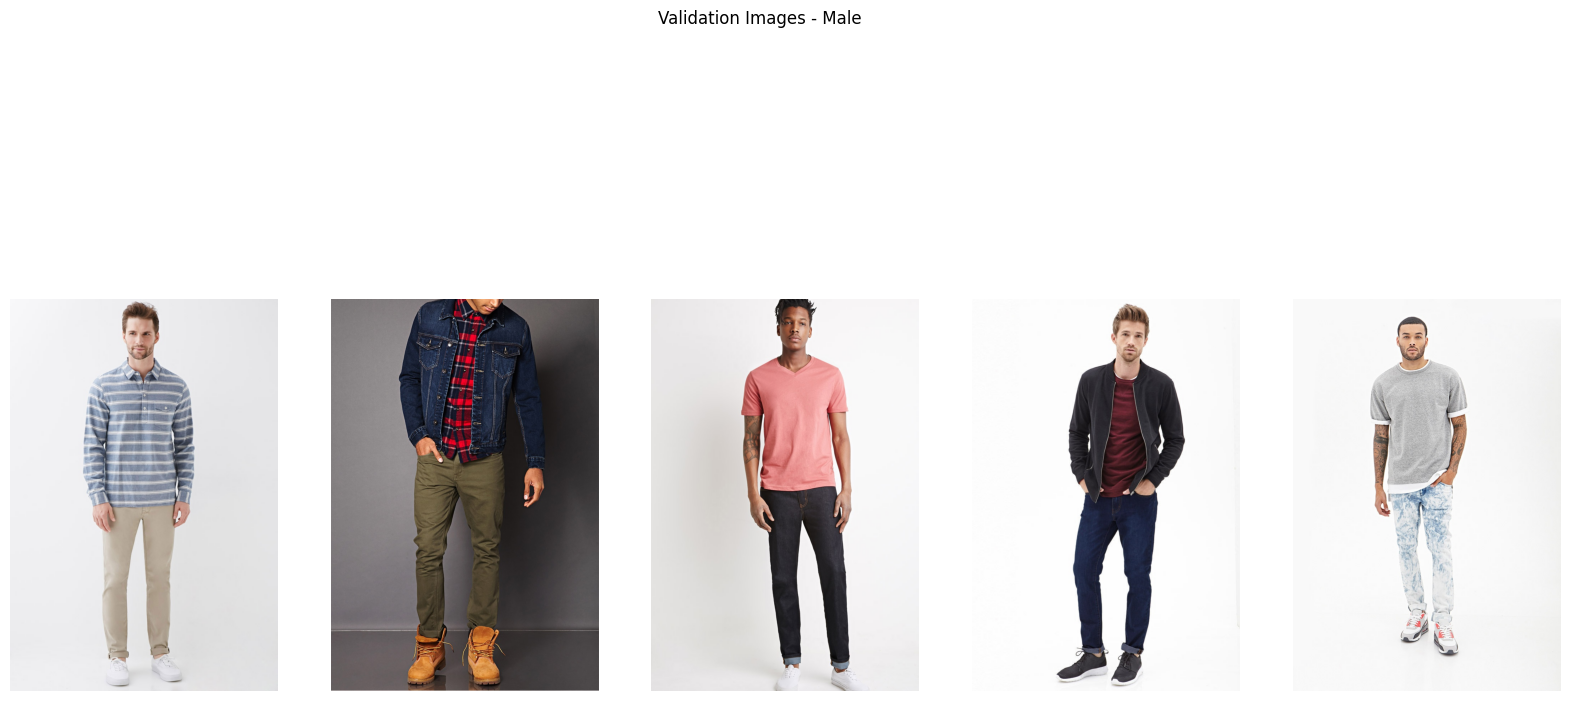

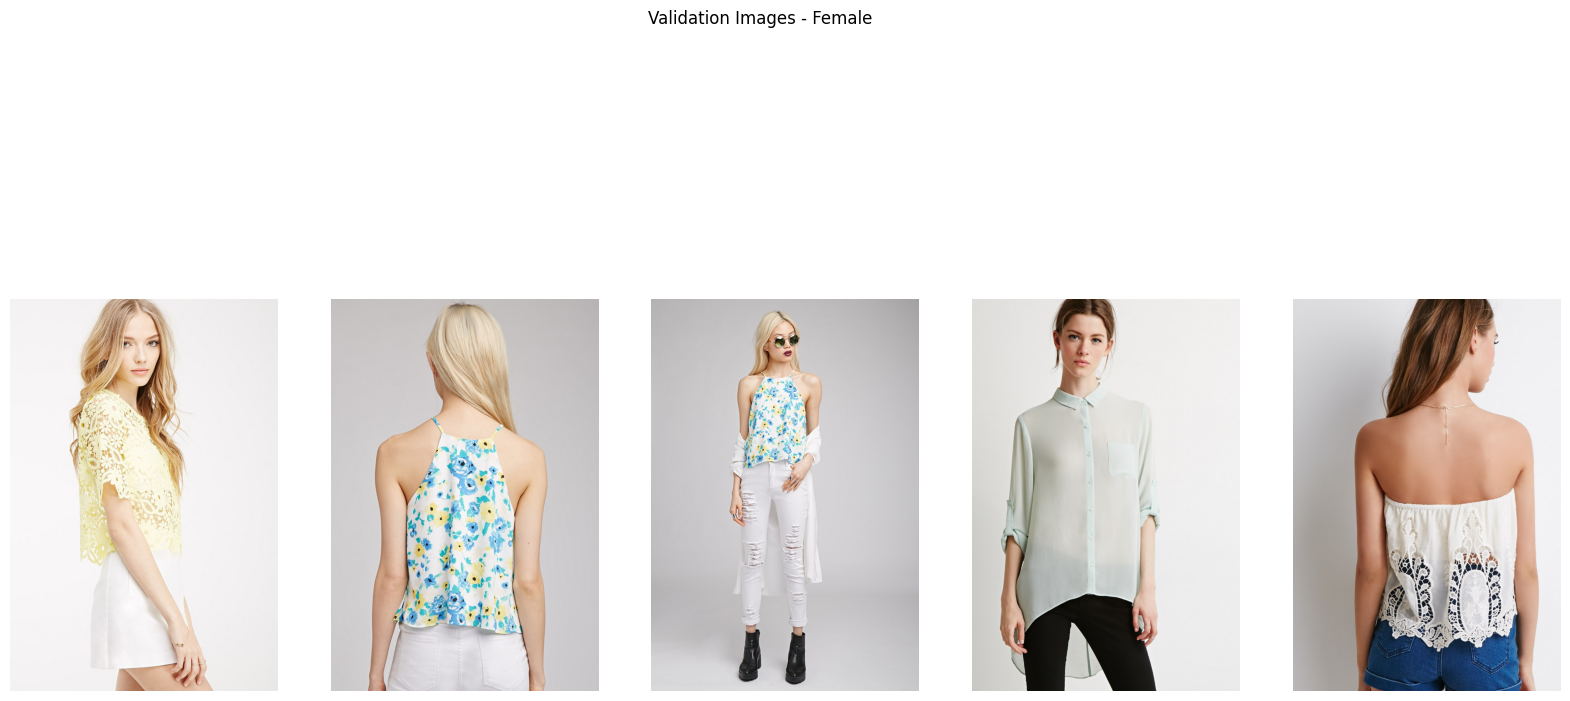

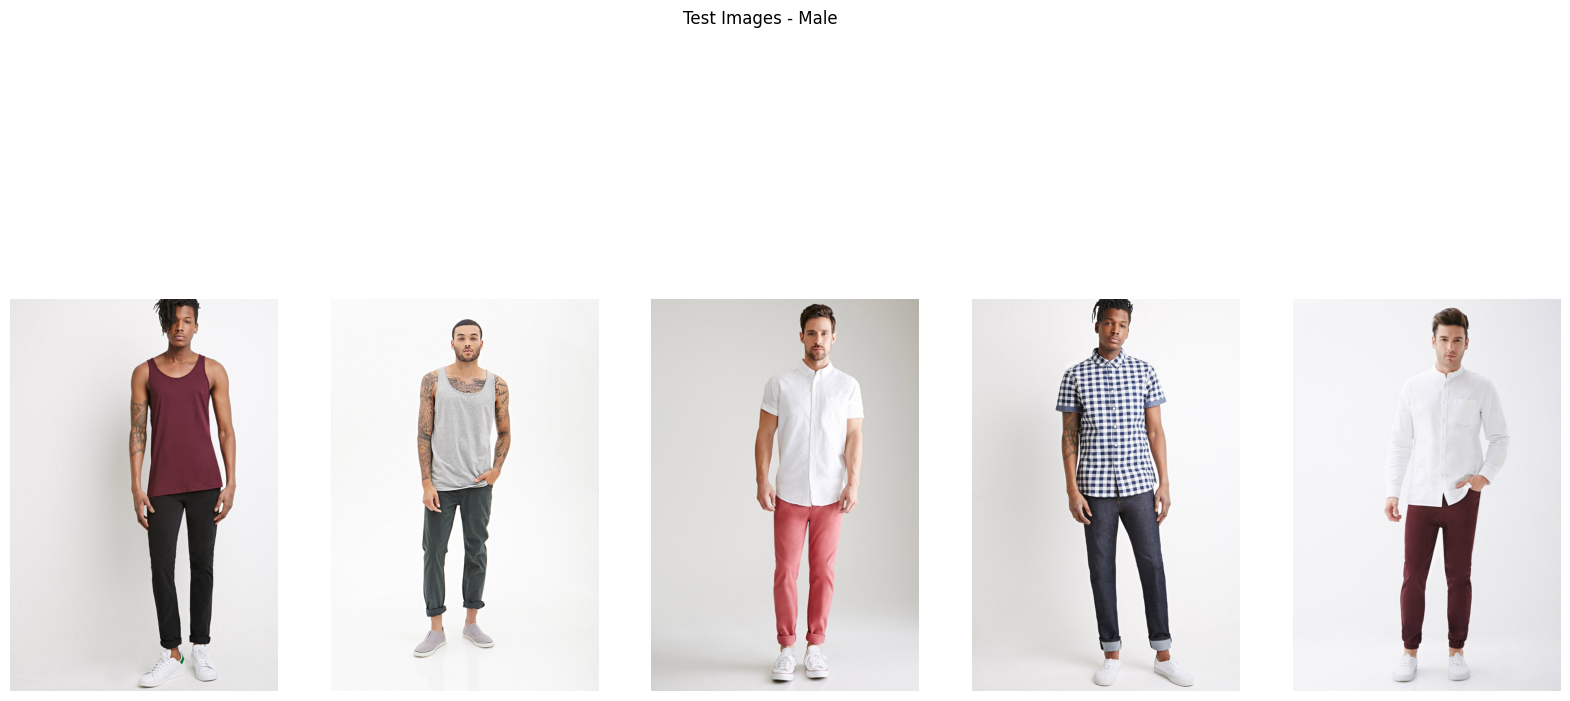

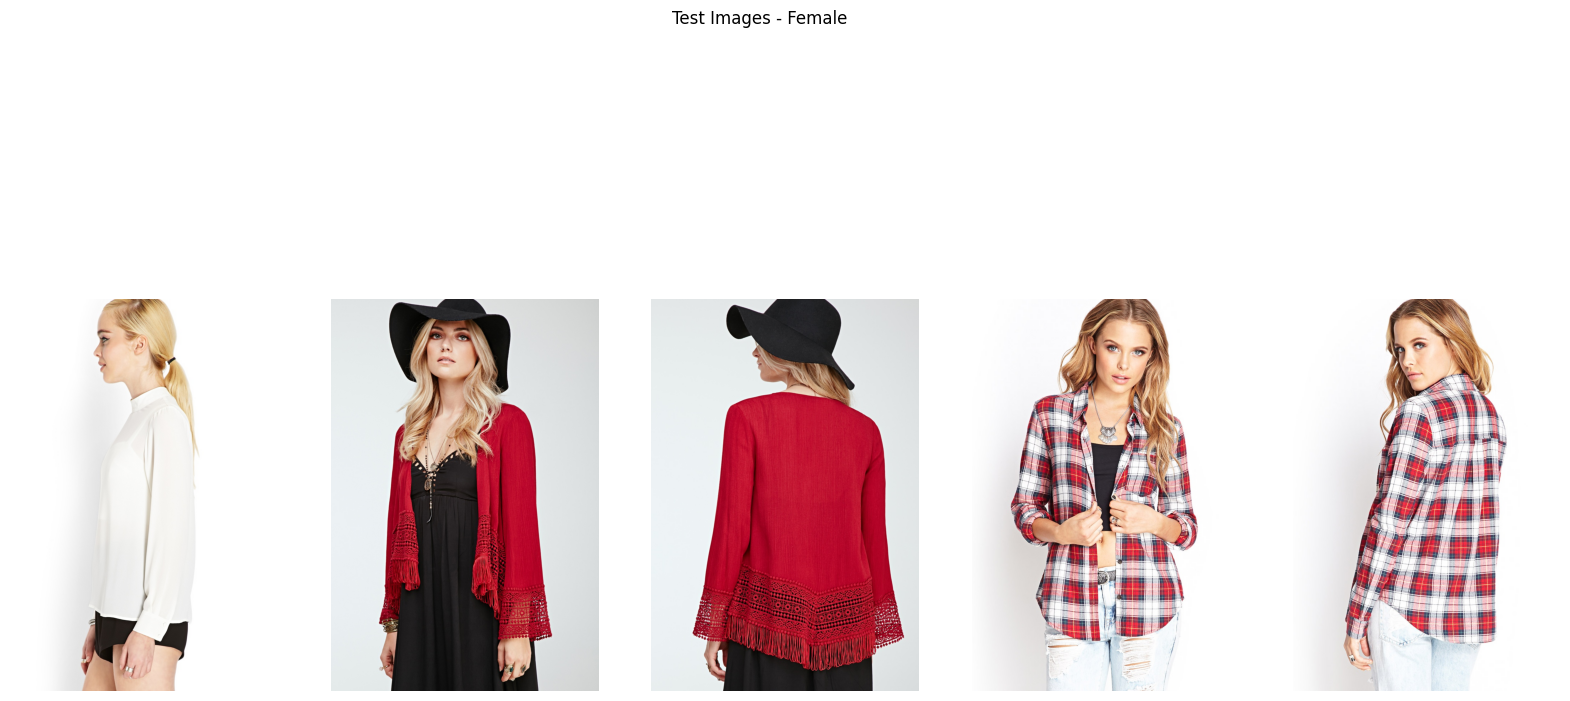

In [24]:
# Display sample images
def display_images(image_paths, title):
    plt.figure(figsize=(20, 10))
    for i, image_path in enumerate(image_paths[:5]):  # Display first 5 images
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample images from each category
train_male_sample = [os.path.join(base_dir, 'train', 'male', img) for img in os.listdir(os.path.join(base_dir, 'train', 'male'))[:5]]
train_female_sample = [os.path.join(base_dir, 'train', 'female', img) for img in os.listdir(os.path.join(base_dir, 'train', 'female'))[:5]]
val_male_sample = [os.path.join(base_dir, 'val', 'male', img) for img in os.listdir(os.path.join(base_dir, 'val', 'male'))[:5]]
val_female_sample = [os.path.join(base_dir, 'val', 'female', img) for img in os.listdir(os.path.join(base_dir, 'val', 'female'))[:5]]
test_male_sample = [os.path.join(base_dir, 'test', 'male', img) for img in os.listdir(os.path.join(base_dir, 'test', 'male'))[:5]]
test_female_sample = [os.path.join(base_dir, 'test', 'female', img) for img in os.listdir(os.path.join(base_dir, 'test', 'female'))[:5]]

display_images(train_male_sample, "Training Images - Male")
display_images(train_female_sample, "Training Images - Female")
display_images(val_male_sample, "Validation Images - Male")
display_images(val_female_sample, "Validation Images - Female")
display_images(test_male_sample, "Test Images - Male")
display_images(test_female_sample, "Test Images - Female")